In [112]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd

plt.rcParams["figure.facecolor"] = "w"

## Appendix: add dataset

In [167]:
def align_burst(burst_info):
    data = []
    col_names = ["burst_f", "burst_range", "burst_amp"]
    for n in range(len(burst_info["burst_f"])):
        for i in range(len(burst_info["burst_f"][n])):
            data_sub = [
                burst_info["burst_f"][n][i],
                burst_info["burst_amp"][n][i],
                burst_info["burst_range"][n][i][1] - burst_info["burst_range"][n][i][0],
                burst_info["cluster_id"][n],
                burst_info["pop_type"][n]
            ]
            data.append(data_sub)
    df_burst = pd.DataFrame(data, columns=["burst_f", "burst_amp", "burst_duration", "cluster_id", "pop_type"])
    if df_burst["cluster_id"].min() == 0:
        df_burst["cluster_id"] += 1
    
    return df_burst

In [184]:
fname = "./burst_info_data2.pkl"

with open(fname, "rb") as fp:
    burst_info = pkl.load(fp)
print(burst_info.keys())

df_burst = align_burst(burst_info)
print(burst_info["params"])

dict_keys(['burst_f', 'burst_range', 'burst_amp', 'cluster_id', 'pop_type', 'params'])
{'std_min': 3.3, 'std_max': 8, 'std_step': 0.1, 'nmin_width': 5}


In [151]:
nc = 1
pop_type = 0


def read_burst(df, target_cluster_id=0, target_pop_type=-1):
    cond = (df["cluster_id"] == target_cluster_id) & (df["pop_type"] == target_pop_type)
    return df[cond]


burst_sub = read_burst(df_burst, target_cluster_id=1, target_pop_type=0)

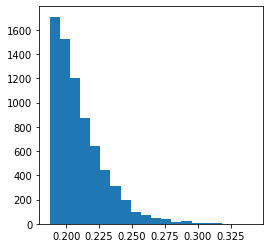

In [152]:
plt.figure(figsize=(4,4))
plt.hist(burst_sub["burst_amp"], 20)
plt.show()

In [153]:
def draw_hist(df, target_cluster_id, figsize=(9, 3.5), dpi=120,
              f_range=(10, 100), amp_range=(0.1, 0.3), t_range=(0., 1), nbin=40,
              norm=False):
    
    keys = ("burst_f", "burst_amp", "burst_duration")
    key_range = (f_range, amp_range, t_range)
    key_labels = (r"$f_{center}$ (Hz)", r"$\langle A \rangle$", r"$T$ (s)")
    cs = ("r", "b")
    pop_labels = (r"$Fast$", r"$Slow$")
    
    num_burst = []
    fig, axs = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
    for n in range(2):
        burst_sub = read_burst(df_burst, target_cluster_id=target_cluster_id, target_pop_type=n)
        num_burst.append(len(burst_sub["burst_f"]))
        for i in range(3):
            r = key_range[i]
            edges = np.linspace(r[0], r[1], nbin)
            
            if keys[i] == "burst_duration":
                dt = 0.15
                edges = np.arange(r[0], r[1]+dt/2, dt)
                
            hist_bin, _ = np.histogram(burst_sub[keys[i]], bins=edges, density=False)
            if norm:
                hist_bin = np.array(hist_bin) / np.sum(hist_bin)
            
            x = (edges[1:] + edges[:-1])/2
            axs[i].plot(x, hist_bin, '.--', lw=1, ms=5, c=cs[n], label=pop_labels[n])
            axs[i].set_xlabel(key_labels[i], fontsize=13)
    
    for i in range(3):
        axs[i].legend(loc="upper right")
        
    plt.suptitle("Cluster id = %d (# burst = %d(F),%d(S))"%(target_cluster_id, num_burst[0], num_burst[1]),
                 fontsize=14, weight="bold")
        
    plt.tight_layout()
    return fig
    

In [191]:
K = len(df_burst["cluster_id"].unique())
range_set = [{} for _ in range(K+1)]
for nc in range(1, K):
    range_set[nc]["f_range"] = (10, 90)
    range_set[nc]["amp_range"] = (0.18, 0.4)
    range_set[nc]["t_range"] = (0, 1.2)

# hard fix
# range_set[0]["amp_range"]  = (0.18, 1.2)

range_set[5]["amp_range"]  = (0.5, 1.2)
range_set[6]["amp_range"]  = (0.28, 0.7)
range_set[7]["amp_range"]  = (0.28, 0.7)
range_set[8]["amp_range"]  = (0.5, 1.2)
range_set[9]["amp_range"]  = (0.28, 0.7)
range_set[10]["amp_range"] = (0.28, 0.7)
range_set[11]["amp_range"] = (0.5, 2)
range_set[12]["amp_range"] = (0.5, 1.2)
range_set[13]["amp_range"] = (0.5, 1.2)
range_set[14]["amp_range"] = (0.5, 2)
range_set[15]["amp_range"] = (0.5, 1.2)

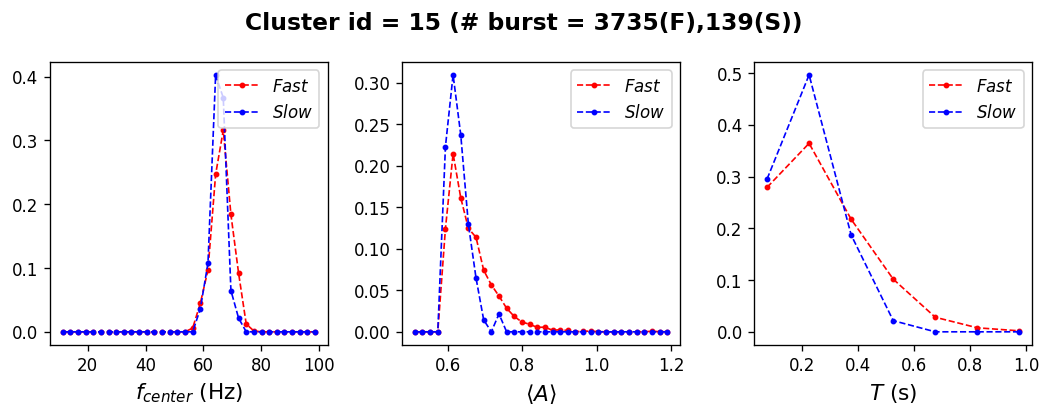

In [192]:
nc = 15
fig = draw_hist(df_burst, nc, norm=True, **range_set[nc], nbin=35)

In [ ]:
for nc in range(1, K+1):
    fig = draw_hist(df_burst, nc, norm=True, **range_set[nc], nbin=35)
    fig.savefig("./figs/burst_info_%02d.png"%(nc), dpi=150)

## Gen joint histogram

In [230]:
df = 2
da = 0.02
f_range = (10, 100)
amp_range = (0.1, 2)

numf = int((f_range[1] - f_range[0]) / df)
numa = int((amp_range[1] - amp_range[0]) / da)

df_sub = df_burst[(df_burst["cluster_id"] == 12) & (df_burst["pop_type"] == 0)]



joint_map = np.zeros([numf, numa])
rset = np.floor((df_sub["burst_f"] - f_range[0]) / df).astype(int)
cset = np.floor((df_sub["burst_amp"] - amp_range[0]) / da).astype(int)

for r, c in zip(rset, cset):
    joint_map[r, c] += 1
joint_map /= len(rset)

In [554]:
from scipy.ndimage import gaussian_filter

def compute_joint(df_burst, cid=1, pop_type=0, itv=(2, 0.02),
                  row_range=(10, 100), col_range=(0.1, 2), sigma=(0, 0)):
    # row: f, col: amp
    if cid < 1: raise ValueError("Wrong cluster id")
    df_sub = df_burst[(df_burst["cluster_id"] == cid) & (df_burst["pop_type"] == pop_type)]
    
    if any(df_sub["burst_f"] >= row_range[1]):
        print("burst_f exceeds expected range, max: %.2f"%(np.max(df_sub["burst_f"])))
    
    if any(df_sub["burst_amp"] >= col_range[1]):
        print("burst_amp exceeds expected range, max: %.2f"%(np.max(df_sub["burst_amp"])))
    
    numf = int((row_range[1] - row_range[0])/itv[0])
    numa = int((col_range[1] - col_range[0])/itv[1])
        
    joint_map = np.zeros([numf, numa])
    rset = np.floor((df_sub["burst_f"] - row_range[0]) / itv[0]).astype(int)
    cset = np.floor((df_sub["burst_amp"] - col_range[0]) / itv[1]).astype(int)
        
    for r, c in zip(rset, cset):
        if r >= numf: continue
        if c >= numa: continue
        
        joint_map[r, c] += 1
        
    if len(rset) > 0: joint_map /= len(rset)
    
    sigma = (int(sigma[0]/itv[0]), int(sigma[1]/itv[1]))
    joint_map = gaussian_filter(joint_map, sigma)
    
    return joint_map, row_range, col_range


def draw_joint_map(joint_map, row_range, col_range, cmap="jet", interpolation="none"):
    dr = (row_range[1] - row_range[0])/joint_map.shape[0]
    dc = (col_range[1] - col_range[0])/joint_map.shape[1]
    plt.imshow(joint_map, interpolation=interpolation, cmap=cmap,
               extent=(col_range[0]-dc, col_range[1]+dc, row_range[0]-dr, row_range[1]+dr),
               aspect="auto", origin="lower", vmin=0)
    # print((row_range[0]-dr, row_range[1]-dr, col_range[0]-dc, col_range[1]-dc))
    

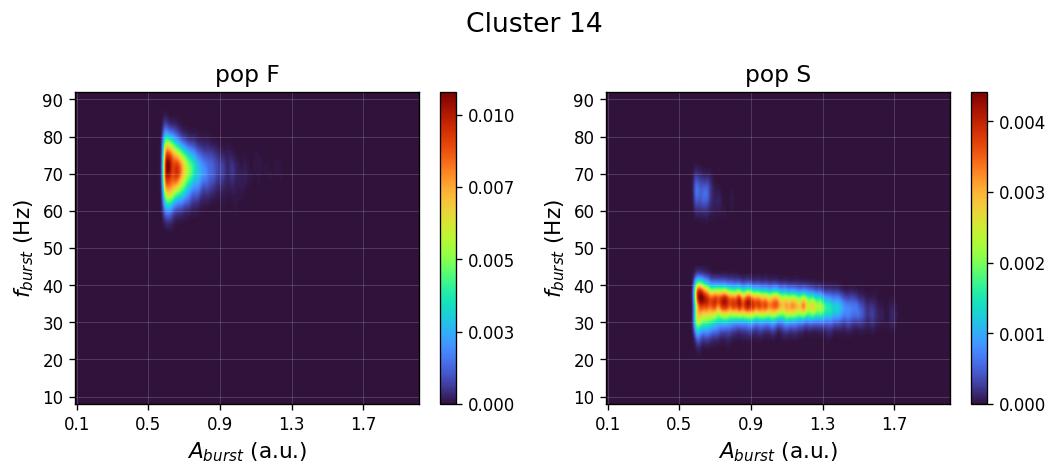

In [552]:
frange = (10, 90)
arange = (0.1, 2)
df = 2
da = 0.01
sigma = (df, da)

cid = 14

def set_labels(frange=None, arange=None, show_xlb=True, show_ylb=True, show_grid=True):
    if show_xlb: plt.xlabel(r"$A_{burst}$ (a.u.)", size=13)
    if show_ylb: plt.ylabel(r"$f_{burst}$ (Hz)", size=13)
    if show_grid: plt.grid(True, lw=0.5, c='w', alpha=0.2)
    plt.yticks(np.arange(frange[0], frange[1]+1, 10))
    plt.xticks(np.arange(arange[0], arange[1]+0.1, 0.4))
    cbar = plt.colorbar(format=lambda x, pos: "{:.3f}".format(x))
    cbar.ax.locator_params(nbins=5)
    
def set_range(val, vlim, dv):
    # set min
    nv = int((np.min(val) - vlim[0])/dv)
    if nv > 0:
        vl_min = 0
    else:
        pass
    
    
    # (np.min(val) - vlim[0])/dv
    # (vlim[1] - vlim[0])/dv

lb_tp = ("F", "S")
plt.figure(dpi=120, figsize=(9, 4))
for tp in range(2):
    joint, _, adj_crange = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=frange, col_range=arange, sigma=sigma)

    plt.subplot(1,2,tp+1)
    draw_joint_map(joint, frange, arange, cmap=cmaps[tp], interpolation="spline16")
    set_labels(frange=frange, arange=arange)
    plt.title("pop %s"%(lb_tp[tp]), fontsize=14)

plt.suptitle("Cluster %d"%(cid), fontsize=16)
plt.tight_layout()
plt.show()

## Generate burst joint map 

In [565]:
frange = (10, 90)
arange = (0.1, 2)
df = 2
da = 0.01
sigma = (df, da)

lb_tp = ("F", "S")
for cid in range(1, 16):
    
    amax = np.max(df_burst[df_burst["cluster_id"] == cid]["burst_amp"])
    col_range = [arange[0], min([arange[1], (int((amax-0.1) // 0.5) + 1) * 0.5])]
    
    plt.figure(dpi=120, figsize=(9, 4))
    for tp in range(2):
        joint, _, adj_crange = compute_joint(df_burst, cid=cid, pop_type=tp, itv=(df, da), row_range=frange, col_range=col_range, sigma=sigma)

        plt.subplot(1,2,tp+1)
        draw_joint_map(joint, frange, col_range, cmap=cmaps[tp], interpolation="spline16")
        set_labels(frange=frange, arange=col_range)
        plt.title("pop %s (n=%d)"%(lb_tp[tp], np.sum((df_burst["cluster_id"] == cid) & (df_burst["pop_type"]==tp))), fontsize=14)

    plt.suptitle("Cluster %d"%(cid), fontsize=16)
    plt.tight_layout()
    plt.savefig("./joint_maps/cid%02d.png"%(cid), dpi=150)
    plt.clf()
    # plt.show()

burst_f exceeds expected range, max: 96.10
burst_amp exceeds expected range, max: 0.51
burst_f exceeds expected range, max: 99.10
burst_amp exceeds expected range, max: 2.04


<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

<Figure size 1080x480 with 0 Axes>

In [440]:
amp = df_burst["burst_amp"][10]

In [441]:
amp

0.2186892515753604

## Check individual

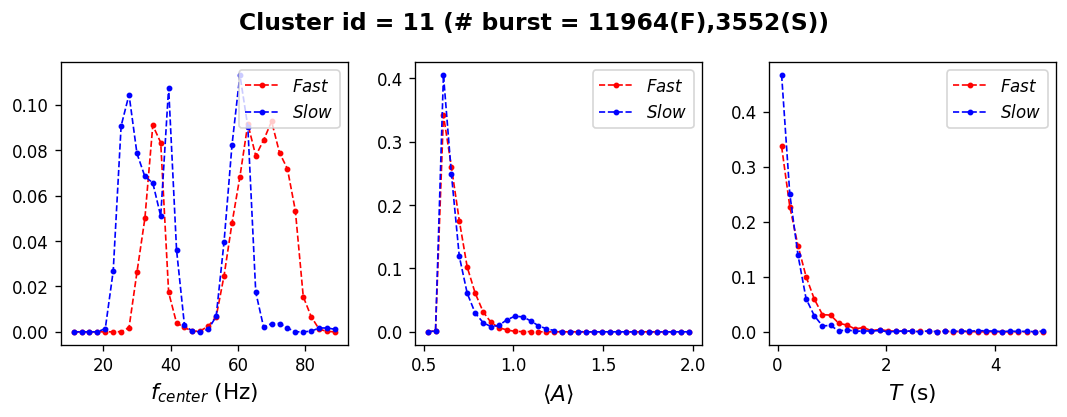

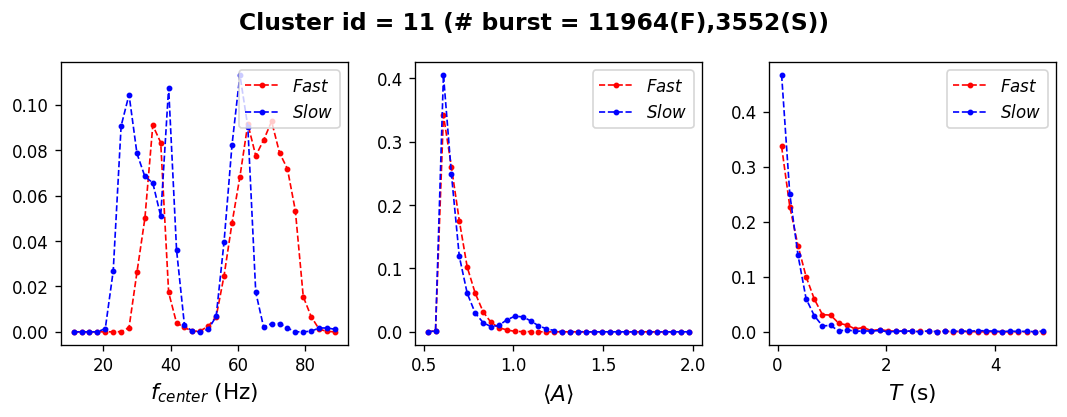

In [151]:
nc = 11

range_tmp = {
    "f_range": (10, 90),
    "amp_range": (0.5, 2),
    "t_range": (0, 5)
}

draw_hist(df_burst, nc, norm=True, **range_tmp, nbin=35)

In [97]:
import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


In [102]:
reload(bt)

<module 'burst_tools' from '/home/jungyoung/Project/hh_neuralnet/gen_three_pop_samples/multifreq_burst/burst_tools.py'>

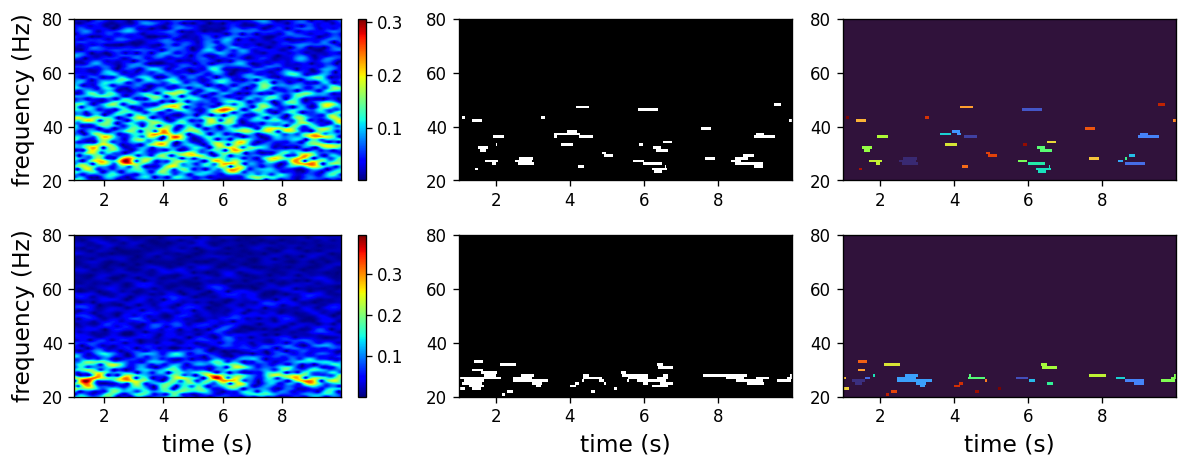

In [111]:
nc = 2
nitr = 50
flim_show = (20, 80)

flim = th_buf["psd_params"]["flim"]
wbin_t = th_buf["psd_params"]["wbin_t"]
mbin_t = th_buf["psd_params"]["mbin_t"]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

fig, axs = plt.subplots(2, 3, figsize=(10, 4), dpi=120, facecolor='w')

for tp in range(2):
    vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
    psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=mbin_t, wbin_t=wbin_t, frange=flim)
    
    ## old version
    pth = th_buf["th_m"][nid, tp] + 3.3 * th_buf["th_s"][nid, tp]
    # im_bin = psd >= pth
    # im_class = bt.find_blob(im_bin)
    # burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, im_class)
    
    burst_map = bt.find_blob_filtration(psd, th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1, nmin_width=int(0.05 // mbin_t))
    burst_f, burst_range, burst_amp = bt.extract_burst_attrib(psd, fpsd, burst_map)
    

    xlb = "time (s)" if tp == 1 else None
    bt.draw_binarize_psd(psd, pth, x=tpsd, y=fpsd, flim=flim_show, ylabel="frequency (Hz)", xlabel=xlb, axs=axs[tp][:2])

    plt.axes(axs[tp][2])
    hhtools.imshow_xy(burst_map, x=tpsd, y=fpsd, cmap="turbo", interpolation="none")
    
    # bt.draw_burst_attrib(im_class, burst_f, burst_range, tpsd=tpsd, fpsd=fpsd, flim=flim_show)
    
    plt.xlabel(xlb, fontsize=14)
    plt.ylim(flim_show)
    plt.tight_layout()

# plt.savefig("./figs/burst_sample.png", dpi=150)
plt.show()

In [109]:
3/100

0.03

## Filtration 

In [1]:
from importlib import reload
import burst_tools as bt
reload(bt)
import pickle as pkl
import hhsignal

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../../include/")

import hhsignal
import hhtools
import burst_tools as bt

summary_obj = hhtools.SummaryLoader("../data/")
with open("./th_data2.pkl", "rb") as fp:
    th_buf = pkl.load(fp)
print(th_buf["std_ratio"])

3.29


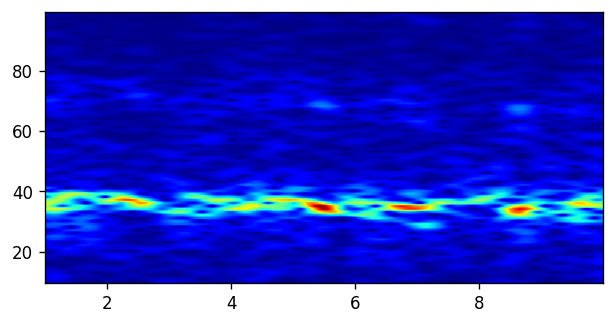

In [87]:
nc = 8
tp  = 1
nitr = 50
flim_show = (20, 80)

def cut_start(signal, t):
    idt = (t >= 0.5)
    return signal[idt], t[idt]

nid = summary_obj.get_id(nc-1, nitr)
detail_data = summary_obj.load_detail(nc-1, nitr)
vlfp, t = cut_start(detail_data["vlfp"][tp+1], detail_data["ts"])
psd, fpsd, tpsd = hhsignal.get_stfft(vlfp, t, 2000, mbin_t=0.01, wbin_t=1, frange=(10, 100))

plt.figure(dpi=120, figsize=(6, 3))
hhtools.imshow_xy(psd, x=tpsd, y=fpsd, cmap='jet')
plt.show()

In [88]:
reload(bt)
burst_map, null_map, im_b = bt.extract_burst_filtration(psd, fpsd,
                                        th_buf["th_m"][nid, tp], th_buf["th_s"][nid, tp],
                                        std_min=3.3, std_max=8, std_step=0.1,
                                        nmin_width=int(0.05/th_buf["psd_params"]["mbin_t"]))

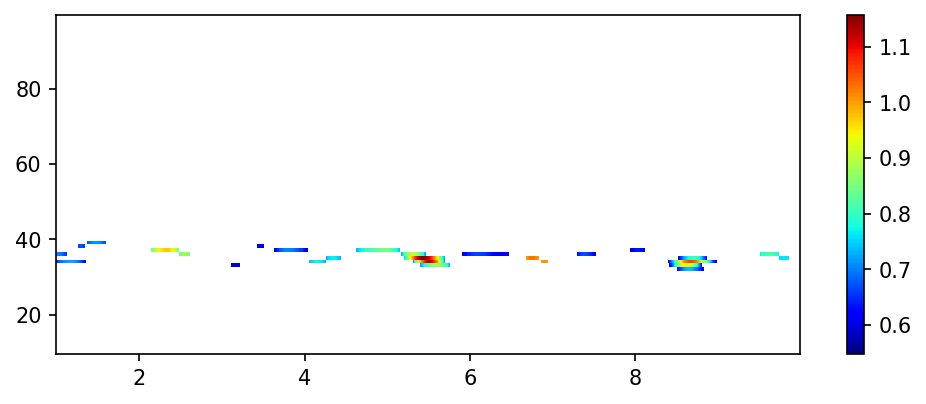

In [91]:
amap = (burst_map > 0).astype(float)
# amap[amap == 0] = 1
pth_min = th_buf["th_m"][nid, tp] + 3 * th_buf["th_s"][nid, tp]

plt.figure(dpi=150, figsize=(8, 3))
hhtools.imshow_xy(psd, alpha=amap, x=tpsd, y=fpsd, cmap="jet", interpolation="none", vmin=pth_min)
plt.colorbar()

In [95]:
width = []
for nb in range(1, np.max(burst_map)+1):
    nr, nc = np.where(burst_map == nb)
    width.append([np.max(nc) - np.min(nc)])

In [97]:
np.min(width)

7

In [65]:
test = bt.extract_burst_attrib(psd, fpsd, burst_map)